#  Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import keras
from keras.preprocessing import image
from keras.utils import to_categorical

from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation

from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.keras import backend as K

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2

2024-05-04 10:59:50.228187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 10:59:50.228307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 10:59:50.338128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploring the data

In [2]:
skin_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'

In [3]:
skin_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')

In [4]:
skin_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
skin_df['diagnosis'].value_counts()

diagnosis
unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: count, dtype: int64

In [6]:
lesion_type_dict = {
    'unknown': "0",
    'nevus': "1",
    'melanoma': "2",
    'seborrheic keratosis': "3",
    'lentigo NOS': "4",
    'lichenoid keratosis': "5",
    'solar lentigo': "6",
    'cafe-au-lait macule':"7",
    'atypical melanocytic proliferation':"8"
}

In [7]:
skin_df["cell_type"] = skin_df["diagnosis"].map(lesion_type_dict.get)

In [8]:
skin_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,cell_type
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,1
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0


# Preparing the train and test data

In [9]:

skin_labels = []
skin_images =[]

for i in range(skin_df.shape[0]):
    skin_images.append(skin_dir+skin_df['image_name'].iloc[i]+'.jpg')
    skin_labels.append(skin_df['cell_type'].iloc[i])

skin_df = pd.DataFrame(skin_images)
skin_df.columns =['images']
skin_df['cell_type'] = skin_labels

In [10]:
skin_df.head()

,images,cell_type
0,/kaggle/input/siim-isic-melanoma-classificatio...,0
1,/kaggle/input/siim-isic-melanoma-classificatio...,0
2,/kaggle/input/siim-isic-melanoma-classificatio...,1
3,/kaggle/input/siim-isic-melanoma-classificatio...,0
4,/kaggle/input/siim-isic-melanoma-classificatio...,0


In [11]:
from skimage.io import imread

skin_df = skin_df.dropna(subset=['images'])

In [12]:
import os

In [13]:
skin_df = skin_df[skin_df['images'].apply(lambda x: os.path.isfile(x))]

In [14]:
skin_df.cell_type.value_counts()

cell_type
0    27124
1     5193
2      584
3      135
4       44
5       37
6        7
7        1
8        1
Name: count, dtype: int64

In [15]:
from sklearn.utils import resample

dx_categories = skin_df['cell_type'].unique()
resampled_dfs = []
for dx in dx_categories:
    dx_data = skin_df[skin_df['cell_type'] == dx]
    resampled_dx = resample(dx_data, replace=True, n_samples=500, random_state=123)
    resampled_dfs.append(resampled_dx)
df_resampled = pd.concat(resampled_dfs)
print(df_resampled['cell_type'].value_counts())

cell_type
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
Name: count, dtype: int64


In [16]:
data = df_resampled.sample(frac=1)

In [17]:
data.head()

,images,cell_type
2186,/kaggle/input/siim-isic-melanoma-classificatio...,5
8200,/kaggle/input/siim-isic-melanoma-classificatio...,0
17719,/kaggle/input/siim-isic-melanoma-classificatio...,3
30473,/kaggle/input/siim-isic-melanoma-classificatio...,6
6864,/kaggle/input/siim-isic-melanoma-classificatio...,5


In [18]:
data.shape

(4500, 2)

In [19]:
from PIL import Image
def resize_images(img):
  file = Image.open(img)
  img = file.convert('RGB')
  img_bgr= img.resize((224, 224))
  img_bgr = np.array(img_bgr)
  return img_bgr

In [20]:
images = [resize_images(img) for img in data['images']]

In [21]:
num_classes = len(np.unique(data['cell_type']))

In [22]:
num_classes

9

In [23]:
class_names = list(data['cell_type'])

In [24]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '4')

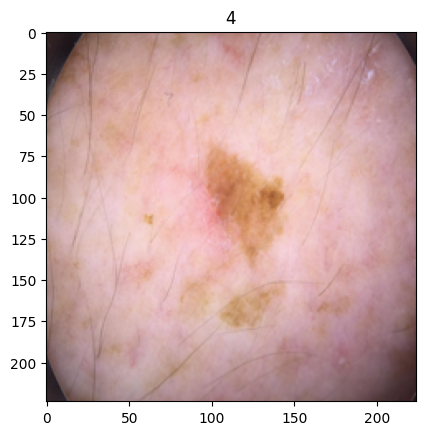

In [25]:
plt.imshow(images[5])
plt.title(class_names[5])

In [26]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(data['cell_type'])

In [27]:
data['cell_type'][:10]

2186     5
8200     0
17719    3
30473    6
6864     5
2024     4
11737    3
6864     5
23824    2
13009    2
Name: cell_type, dtype: object

In [28]:
images = np.array(images)

In [29]:
images.shape

(4500, 224, 224, 3)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2,stratify = y,random_state=42)

In [31]:
X_train.shape

(3600, 224, 224, 3)

In [32]:
X_test.shape

(900, 224, 224, 3)

In [33]:
y_train.shape

(3600, 9)

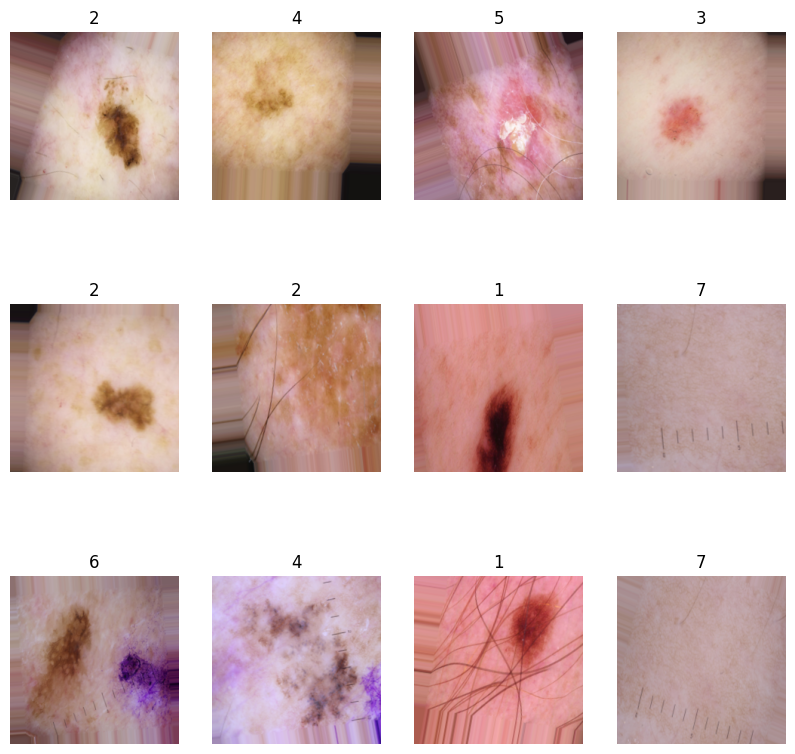

In [34]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(X_train)


plt.figure(figsize=(10, 10))
counter = 1
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=12):
    for i in range(12):
        ax = plt.subplot(3, 4, counter)
        plt.imshow(X_batch[i].astype("uint8"))
        plt.title(np.argmax(y_batch[i]))
        plt.axis("off")
        counter += 1
    if counter > 12:
        break

plt.show()

In [35]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout ,GlobalAveragePooling2D ,Concatenate , Input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

X_train_preprocessed = preprocess_input(X_train)
X_test_preprocessed = preprocess_input(X_test)


Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
DenseNet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_model.layers:
    layer._name = 'vgg16_' + layer.name  

for layer in DenseNet121_model.layers:
    layer._name = 'DenseNet121_model_' + layer.name  


for layer in Xception_model.layers:
    layer.trainable = False
for layer in DenseNet121_model.layers:
    layer.trainable = False
for layer in vgg16_model.layers:
    layer.trainable = False

input_tensor = Input(shape=(224, 224, 3))
Xception_output = Xception_model(input_tensor)
DenseNet121_output = DenseNet121_model(input_tensor)
vgg16_output = vgg16_model(input_tensor)


Xception_pooled_output = GlobalAveragePooling2D()(Xception_output)
DenseNet121_pooled_output = GlobalAveragePooling2D()(DenseNet121_output)
vgg16_pooled_output = GlobalAveragePooling2D()(vgg16_output)

concatenated_outputs = Concatenate()([Xception_pooled_output, DenseNet121_pooled_output, vgg16_pooled_output])

x = Dense(1024, activation='relu')(concatenated_outputs)
final_output = Dense(9, activation='softmax')(x)  

model = Model(inputs=input_tensor, outputs=final_output)


optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')

# Compile the model (fix potential typo)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 7, 7,      │ 20,861,480 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 7, 7,      │  7,037,504 │ input_layer_3[0]… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3584)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  3,671,040 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │      9,225 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,293,937 (176.60 MB)

 Trainable params: 3,680,265 (14.04 MB)

 Non-trainable params: 42,613,672 (162.56 MB)

In [37]:
history_vgg16 = model.fit(X_train_preprocessed, y_train,
                        epochs=30,
                        validation_data=(X_test_preprocessed, y_test),
                        batch_size=64)

Epoch 1/30


I0000 00:00:1714821572.785188     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714821572.885209     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4822 - loss: 2.9745   

W0000 00:00:1714821651.601558     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714821666.235412     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.4844 - loss: 2.9522 - val_accuracy: 0.6278 - val_loss: 0.9242
Epoch 2/30


W0000 00:00:1714821698.298457     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 795ms/step - accuracy: 0.7509 - loss: 0.7340 - val_accuracy: 0.7933 - val_loss: 0.6212
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 785ms/step - accuracy: 0.8369 - loss: 0.4789 - val_accuracy: 0.7622 - val_loss: 0.6698
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 790ms/step - accuracy: 0.8620 - loss: 0.3836 - val_accuracy: 0.7811 - val_loss: 0.7101
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 785ms/step - accuracy: 0.8974 - loss: 0.3096 - val_accuracy: 0.9000 - val_loss: 0.3020
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 787ms/step - accuracy: 0.9225 - loss: 0.2207 - val_accuracy: 0.8967 - val_loss: 0.2864
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 792ms/step - accuracy: 0.9406 - loss: 0.1827 - val_accuracy: 0.9178 - val_loss: 0.2437
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 789ms/step - accuracy: 0.9430 - loss: 0.1570 - val_accuracy: 0.9000 - val_loss: 0.3058
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 787ms/step - accuracy: 0.9619 - loss: 0.1280 - val_accuracy: 0.878

In [38]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics

In [39]:
predictions = model.predict(X_test_preprocessed)
predicted_classes = predictions.argmax(axis=-1) 

 1/29 ━━━━━━━━━━━━━━━━━━━━ 32:59 71s/step

W0000 00:00:1714823071.172849     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 92s 756ms/step


W0000 00:00:1714823092.329080     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [40]:
va_y=[]
for i in y_test:
    va_y.append(np.argmax(i))
y_test_array = np.array(va_y)
class_names = ['unknown','nevus','melanoma','seborrheic keratosis','lentigo NOS','lichenoid keratosis','solar lentigo','cafe-au-lait macule','atypical melanocytic proliferation']

In [41]:
report = classification_report(y_test_array, predicted_classes, target_names=class_names)

print(report)

                                    precision    recall  f1-score   support

                           unknown       0.81      0.71      0.76       100
                             nevus       0.94      0.88      0.91       100
                          melanoma       0.77      0.80      0.78       100
              seborrheic keratosis       0.90      0.99      0.94       100
                       lentigo NOS       0.98      1.00      0.99       100
               lichenoid keratosis       1.00      1.00      1.00       100
                     solar lentigo       0.98      1.00      0.99       100
               cafe-au-lait macule       1.00      1.00      1.00       100
atypical melanocytic proliferation       1.00      1.00      1.00       100

                          accuracy                           0.93       900
                         macro avg       0.93      0.93      0.93       900
                      weighted avg       0.93      0.93      0.93       900

